# Redoing Bedny (2019) analysis, comparing to word embeddings

## Load ppt data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import numpy as np
from tqdm import tqdm
import scipy

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [3]:
df_participant_judgments = pd.read_csv("data/datalong_CBSAMT.csv")

In [4]:
df_participant_judgments.head(5)

,C1,C2,S1,S2,Category,V1,V2,S_01,S_02,S_03,...,CB_31,CB_32,CB_33,CB_34,CB_35,CB_37,CB_38,CB_40,CB_41,AMT_av
0,Sound,Sound,Sanim,Sinanim,Emission,bark,beep,1,3,4,...,1,1.0,1.0,1.0,2.0,1.0,2,1.0,2.0,2.351351
1,Sound,Sound,Sanim,Sanim,Emission,bark,bellow,1,5,5,...,1,4.0,4.0,7.0,4.0,4.0,3,1.0,5.0,4.705882
2,Sound,Light,Sanim,Light,Emission,bark,blaze,1,1,1,...,1,1.0,1.0,6.0,1.0,1.0,1,1.0,5.0,2.184211
3,Sound,Light,Sanim,Light,Emission,bark,blink,1,1,4,...,1,1.0,1.0,7.0,1.0,1.0,1,1.0,2.0,1.657895
4,Sound,Sound,Sanim,Sinanim,Emission,bark,boom,2,3,4,...,1,1.0,1.0,6.0,1.0,4.0,3,1.0,5.0,4.228571


In [5]:
len(df_participant_judgments)

2806

### Get cosine distances for each wordpair

In [6]:
from allennlp.commands.elmo import ElmoEmbedder

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [8]:
elmo = ElmoEmbedder()

In [9]:
sims = []
for index, row in tqdm(list(df_participant_judgments.iterrows())):
    w1, w2 = row['V1'], row['V2']
    
    w1_contextualized = elmo.embed_sentence(["to", w1])[2][-1].tolist()
    w2_contextualized = elmo.embed_sentence(["to", w2])[2][-1].tolist()
    
    sim = scipy.spatial.distance.cosine(w1_contextualized, w2_contextualized)
    
    sims.append(sim)

100%|██████████| 2806/2806 [20:18<00:00,  2.77it/s]


In [10]:
df_participant_judgments['cosine_distance'] = sims

In [11]:
df_participant_judgments.to_csv("data/processed/judgments_with_distances.csv")

### Merge with cosine distances for each wordpair

In [7]:
df_analysis = pd.read_csv("data/processed/verb_embedding_distances.csv")
df_analysis.head(5)

,Unnamed: 0,cosine_distance,w1,w2
0,0,0.900461,blaze,blink
1,1,0.780368,blaze,flare
2,2,0.929387,blaze,flash
3,3,0.865661,blaze,flicker
4,4,0.856313,blaze,gleam


In [13]:
def combine_words(row, word1='w1', word2='w2'):
    w1, w2 = row[word1], row[word2]
    return '_'.join(sorted([w1, w2]))

In [14]:
df_participant_judgments['combined_words'] = df_participant_judgments.apply(
    lambda row: combine_words(row, word1='V1', word2='V2'), axis=1)

In [15]:
df_analysis['combined_words'] = df_analysis.apply(lambda row: combine_words(row), axis=1)

In [16]:
df_analysis_subset = df_analysis[df_analysis['combined_words'].isin(list(df_participant_judgments['combined_words']))]

In [17]:
len(df_analysis_subset)

2027

In [18]:
df_merged = pd.merge(df_analysis, df_participant_judgments, on="combined_words")

In [19]:
len(df_merged)

2027

In [20]:
df_merged.head(5)

,Unnamed: 0,cosine_distance_x,w1,w2,combined_words,C1,C2,S1,S2,Category,...,CB_32,CB_33,CB_34,CB_35,CB_37,CB_38,CB_40,CB_41,AMT_av,cosine_distance_y
0,0,0.900461,blaze,blink,blaze_blink,Light,Light,Light,Light,Emission,...,1.0,3.0,1.0,1.0,1.0,3,1.0,2.0,2.000,0.396978
1,1,0.780368,blaze,flare,blaze_flare,Light,Light,Light,Light,Emission,...,4.0,4.0,7.0,4.0,7.0,5,7.0,6.0,4.725,0.297949
2,2,0.929387,blaze,flash,blaze_flash,Light,Light,Light,Light,Emission,...,5.0,4.0,7.0,3.0,7.0,4,4.0,6.0,4.025,0.451643
3,3,0.865661,blaze,flicker,blaze_flicker,Light,Light,Light,Light,Emission,...,2.0,3.0,1.0,1.0,7.0,3,3.0,3.0,3.750,0.369473
4,4,0.856313,blaze,gleam,blaze_gleam,Light,Light,Light,Light,Emission,...,2.0,3.0,4.0,1.0,7.0,5,5.0,4.0,3.225,0.348881


In [21]:
df_merged.to_csv("data/processed/judgments_with_embeddings.csv")

## Do cosine distances predict average similarity judgments?

Here, we want to ask whether the cosine distance between two words in vector-space predicts how similar those words will be judged to be.

Specifically, we are interested in whether the predictive power of **cosine distance**––taken as a proxy for "distributional properties of language"––is differentially successful across modalities, across different groups. For example, one might expect that distributional properties better capture similarity judgments of **amodal** verbs overall, simply because that information is likely to come through language, rather than through embodied, grounded experience (Lupyan and Winter, 2018). Additionally, one might expect that distributional properties play a bigger role in **blind** participants' representations of **vision verbs** than sighted participants, because blind participants do not have direct access to that modality.

In [7]:
import statsmodels.formula.api as sm

### Get data into shape

In [6]:
# df_merged = pd.read_csv("data/processed/judgments_with_embeddings.csv")

In [4]:
df_merged = pd.read_csv("data/processed/judgments_with_distances.csv")


In [5]:
df_merged['same_modality'] = df_merged['C1'] == df_merged['C2']

In [6]:
sighted_columns = ['S_01', 'S_02', 'S_03', 'S_04', 'S_05', 'S_07',
       'S_08', 'S_09', 'S_10', 'S_11', 'S_12', 'S_13', 'S_14', 'S_16', 'S_17',
       'S_18', 'S_19', 'S_20', 'S_21', 'S_22', 'S_23', 'S_24']
blind_columns = ['CB_06',
       'CB_08', 'CB_09', 'CB_14', 'CB_15', 'CB_18', 'CB_19', 'CB_22', 'CB_23',
       'CB_24', 'CB_25', 'CB_26', 'CB_27', 'CB_28', 'CB_29', 'CB_30', 'CB_31',
       'CB_32', 'CB_33', 'CB_34', 'CB_35', 'CB_37', 'CB_38', 'CB_40', 'CB_41']

In [8]:
def get_group_average(row, columns):
    row = row.fillna(0)
    row_col = row[columns].values
    # row_col = [i for i in row_col if i >0 ]
    return row_col.mean()

In [9]:
df_merged['blind_avg'] = df_merged.apply(lambda x: get_group_average(x, columns=blind_columns), 
                                         axis=1)

In [10]:
df_merged['sighted_avg'] = df_merged.apply(lambda x: get_group_average(x, columns=sighted_columns), 
                                         axis=1)

In [11]:
modalities = {'Light': 'Vision',
             'Sound': 'Sound',
             'Touch': 'Touch',
             'Amodal': 'Amodal',
              'Motion': 'Motion',
              'Sight': 'Vision'}

df_merged['Cat1'] = df_merged['C1'].apply(lambda x: modalities[x])
df_merged['Cat2'] = df_merged['C2'].apply(lambda x: modalities[x])

### Get overall R^2 for each group, for each modality

In [13]:
df_same = df_merged[df_merged['same_modality']==True]

#### Inter-group correlations

In [14]:
modality_to_r2 = []

for modality in ['Vision', 'Sound', 'Touch', 'Amodal', 'Motion']:
    df_reduced = df_same[df_same['Cat1']==modality]
    result_blind_sighted = sm.ols(formula='blind_avg ~ sighted_avg',
                                 data = df_reduced).fit()
    # result_blind_sighted.summary()
    
        
    modality_to_r2.append({
        'r2': result_blind_sighted.rsquared_adj,
        'modality': modality
    })

In [15]:
df_m = pd.DataFrame(modality_to_r2)
df_m

,modality,r2
0,Vision,0.738438
1,Sound,0.845221
2,Touch,0.807057
3,Amodal,0.845248
4,Motion,0.815167


#### Approach 1: Divide modality by `vision`, `sound`, etc.

In [16]:
df_same = df_merged[df_merged['same_modality']==True]

In [17]:
modality_to_r2 = []

for modality in ['Vision', 'Sound', 'Touch', 'Amodal', 'Motion']:
    df_reduced = df_same[df_same['Cat1']==modality]
    
# for modality in set(df_merged['S1']):
#    df_reduced = df_same[df_same['S1']==modality]
    
    print(modality)
    print(len(df_reduced))
    
    result_mturk = sm.ols(formula="AMT_av ~ cosine_distance", data=df_reduced).fit()
    result_blind = sm.ols(formula="blind_avg ~ cosine_distance", data=df_reduced).fit()
    result_sighted = sm.ols(formula="sighted_avg ~ cosine_distance", data=df_reduced).fit()
    
    modality_to_r2.append({
        'r2': result_mturk.rsquared_adj,
        'coef': result_mturk.params['cosine_distance'],
        'sem': result_mturk.bse['cosine_distance'],
        'ppt': 'mturk',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': result_blind.rsquared_adj,
        'coef': result_blind.params['cosine_distance'],
        'sem': result_blind.bse['cosine_distance'],
        'ppt': 'blind',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': result_sighted.rsquared_adj,
        'coef': result_sighted.params['cosine_distance'],
        'sem': result_sighted.bse['cosine_distance'],
        'ppt': 'sighted',
        'modality': modality
    })

Vision
196
Sound
435
Touch
105
Amodal
435
Motion
105


In [40]:
df_modality_r2 = pd.DataFrame(modality_to_r2)

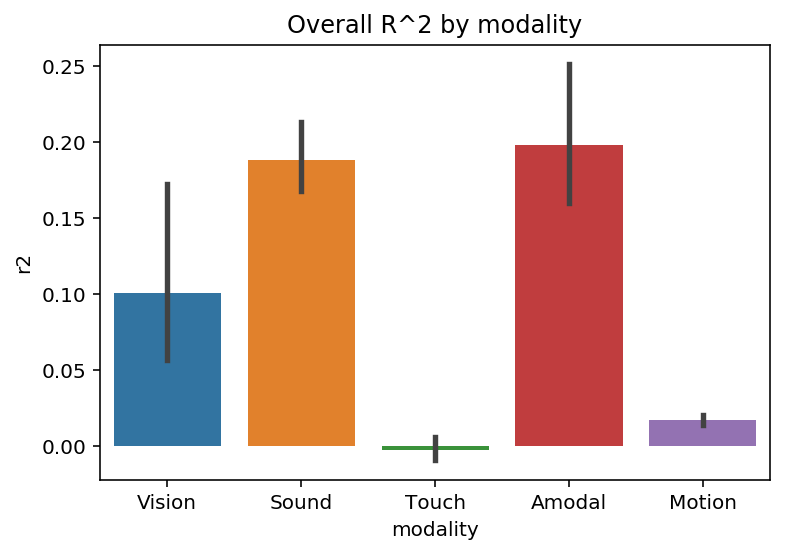

In [43]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2")
plt.title("Overall R^2 by modality")
plt.savefig("Figures/blind_sighted/overall_modality_r2.png", dpi=300)

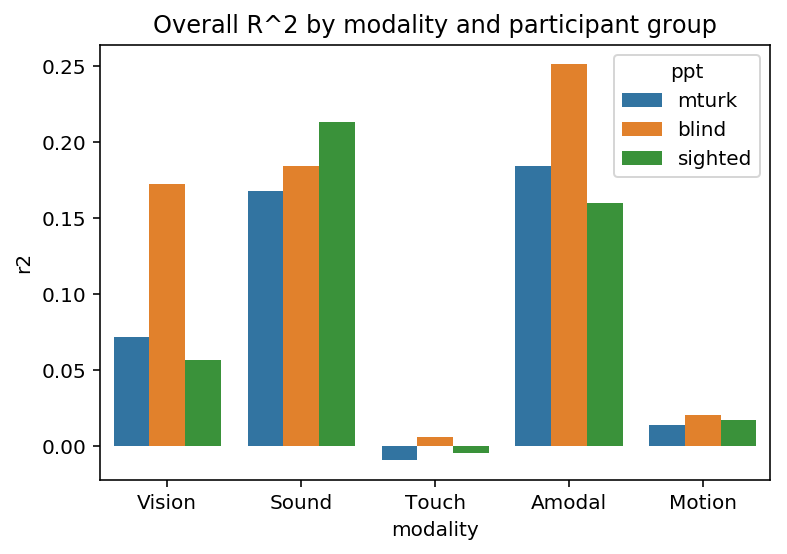

In [44]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2", hue="ppt")
plt.title("Overall R^2 by modality and participant group")
plt.savefig("Figures/blind_sighted/breakdown_modality_r2.png", dpi=300)

In [45]:
def grouped_barplot(df, cat,subcat, val , err):
    """Just for making barplots with error bars."""
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.show()

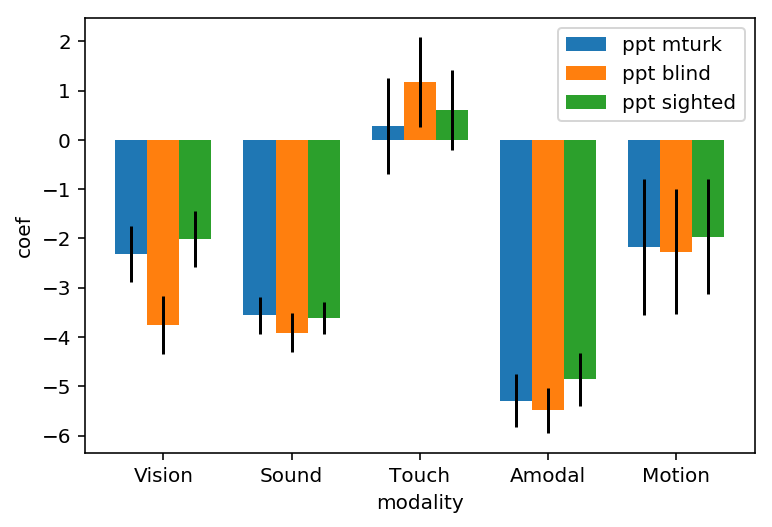

In [47]:
grouped_barplot(df_modality_r2, 'modality', 'ppt', 'coef', 'sem' )

#### Approach 2: Divide modality by `sight`/`light`, etc.

In [28]:
df_same = df_merged[df_merged['same_modality']==True]

In [29]:
modality_to_r2 = []

for modality in set(df_merged['S1']):
    df_reduced = df_same[df_same['S1']==modality]
    
    print(modality)
    print(len(df_reduced))
    
    result_mturk = sm.ols(formula="AMT_av ~ cosine_distance", data=df_reduced).fit()
    result_blind = sm.ols(formula="blind_avg ~ cosine_distance", data=df_reduced).fit()
    result_sighted = sm.ols(formula="sighted_avg ~ cosine_distance", data=df_reduced).fit()
    
    modality_to_r2.append({
        'r2': result_mturk.rsquared_adj,
        'coef': result_mturk.params['cosine_distance'],
        'sem': result_mturk.bse['cosine_distance'],
        'ppt': 'mturk',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': result_blind.rsquared_adj,
        'coef': result_blind.params['cosine_distance'],
        'sem': result_blind.bse['cosine_distance'],
        'ppt': 'blind',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': result_sighted.rsquared_adj,
        'coef': result_sighted.params['cosine_distance'],
        'sem': result_sighted.bse['cosine_distance'],
        'ppt': 'sighted',
        'modality': modality
    })

Motion
105
Light
105
Sinanim
267
Amodal
215
Mental
220
Sight
91
Sanim
168
Touch
105


In [30]:
df_modality_r2 = pd.DataFrame(modality_to_r2)

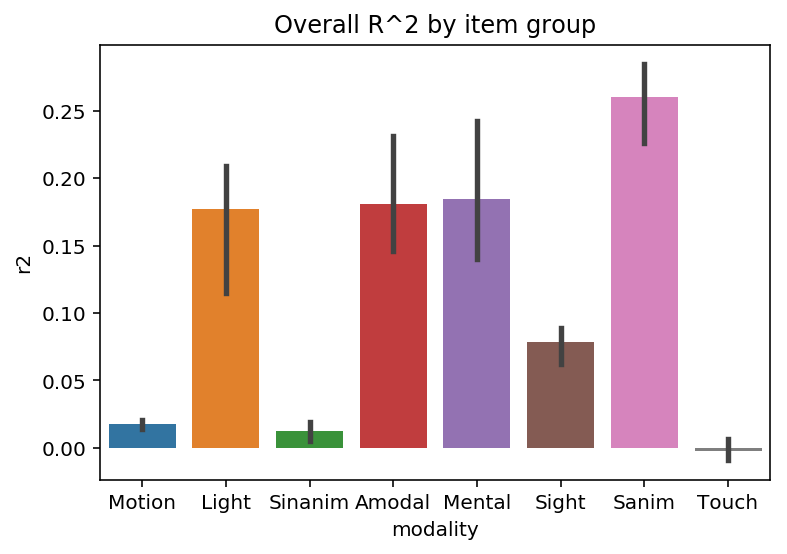

In [33]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2")
plt.title("Overall R^2 by item group")
plt.savefig("Figures/blind_sighted/breakdown_item_group_r2.png", dpi=300)

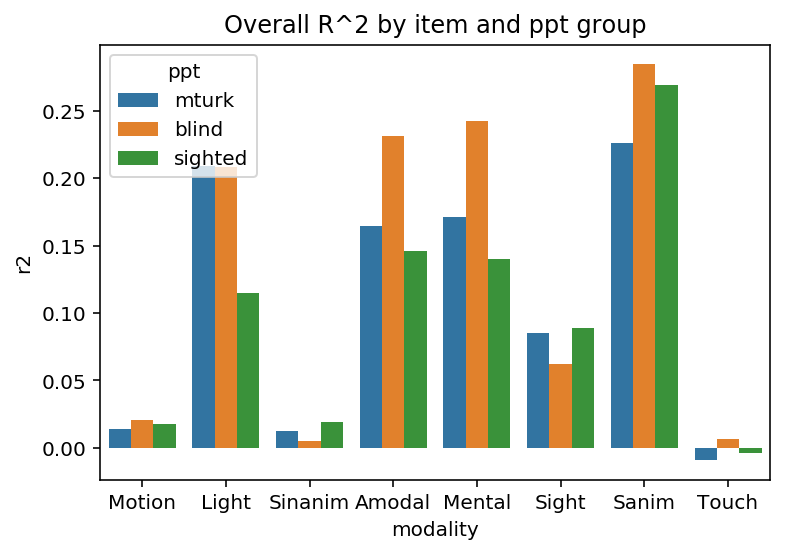

In [35]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2", hue="ppt")
plt.title("Overall R^2 by item and ppt group")
plt.savefig("Figures/blind_sighted/breakdown_ppt_item_group_r2.png", dpi=300)

In [35]:
def grouped_barplot(df, cat,subcat, val , err):
    """Just for making barplots with error bars."""
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.show()

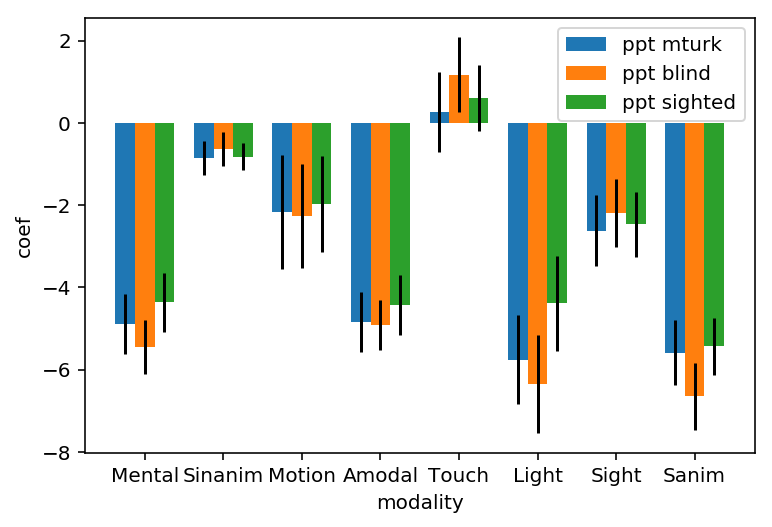

In [36]:
grouped_barplot(df_modality_r2, 'modality', 'ppt', 'coef', 'sem' )

### Compare coefficients for blind vs. sighted, when controlling for MTurk Estimates

Here, we ask whether the observed difference in coefficient size persists once we regress out MTurk estimates of similarity. E.g., does **cosine distance** still have predictive power about the similarity between two verbs even after controlling for other human similarity judgments about those verbs? And does it have *more* predictive power for blind or sighted participants? 

#### Approach 1: Divide modality by `Vision`/`Sound`, etc.

In [37]:
df_same = df_merged[df_merged['same_modality']==True]

In [38]:
modality_to_coef = []


for modality in ['Vision', 'Sound', 'Touch', 'Amodal', 'Motion']:
    df_reduced = df_same[df_same['Cat1']==modality]

# for modality in set(df_merged['S1']):
#    df_reduced = df_same[df_same['S1']==modality]

    result_blind = sm.ols(formula="blind_avg ~ cosine_distance + AMT_av", data=df_reduced).fit()
    result_sighted = sm.ols(formula="sighted_avg ~ cosine_distance + AMT_av", data=df_reduced).fit()
    modality_to_coef.append({
        'r2': result_blind.rsquared_adj,
        'coef_cosine': result_blind.params['cosine_distance'],
        'coef_mturk': result_blind.params['AMT_av'],
        'sem_cosine': result_blind.bse['cosine_distance'],
        'ppt': 'blind',
        'modality': modality
    })
    modality_to_coef.append({
        'r2': result_sighted.rsquared_adj,
        'coef_cosine': result_sighted.params['cosine_distance'],
        'coef_mturk': result_sighted.params['AMT_av'],
        'sem_cosine': result_sighted.bse['cosine_distance'],
        'ppt': 'sighted',
        'modality': modality
    })

In [39]:
df_modality_coef = pd.DataFrame(modality_to_coef)

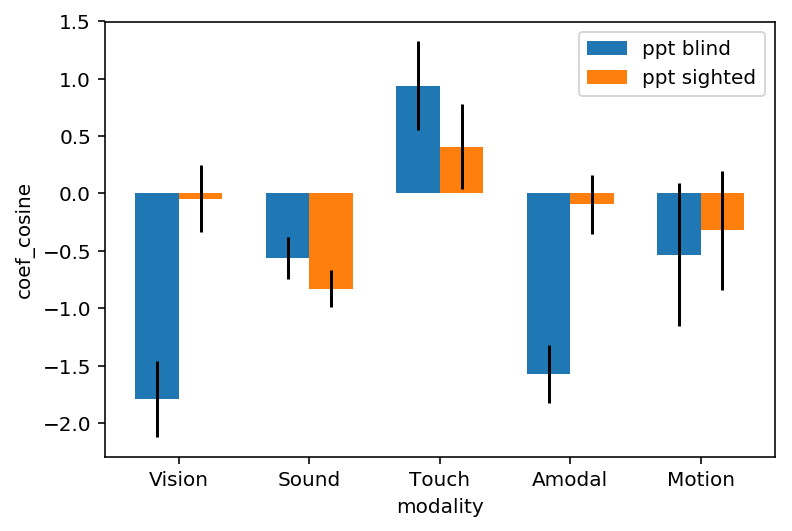

In [40]:
grouped_barplot(df_modality_coef, 'modality', 'ppt', 'coef_cosine', 'sem_cosine' )

#### Approach 2: Divide modality by `sight`/`light`, etc.

In [41]:
df_same = df_merged[df_merged['same_modality']==True]

In [43]:
modality_to_coef = []

for modality in set(df_merged['S1']):
    df_reduced = df_same[df_same['S1']==modality]

    result_blind = sm.ols(formula="blind_avg ~ cosine_distance + AMT_av", data=df_reduced).fit()
    result_sighted = sm.ols(formula="sighted_avg ~ cosine_distance + AMT_av", data=df_reduced).fit()
    modality_to_coef.append({
        'r2': result_blind.rsquared_adj,
        'coef_cosine': result_blind.params['cosine_distance'],
        'coef_mturk': result_blind.params['AMT_av'],
        'sem_cosine': result_blind.bse['cosine_distance'],
        'ppt': 'blind',
        'modality': modality
    })
    modality_to_coef.append({
        'r2': result_sighted.rsquared_adj,
        'coef_cosine': result_sighted.params['cosine_distance'],
        'coef_mturk': result_sighted.params['AMT_av'],
        'sem_cosine': result_sighted.bse['cosine_distance'],
        'ppt': 'sighted',
        'modality': modality
    })

In [44]:
df_modality_coef = pd.DataFrame(modality_to_coef)

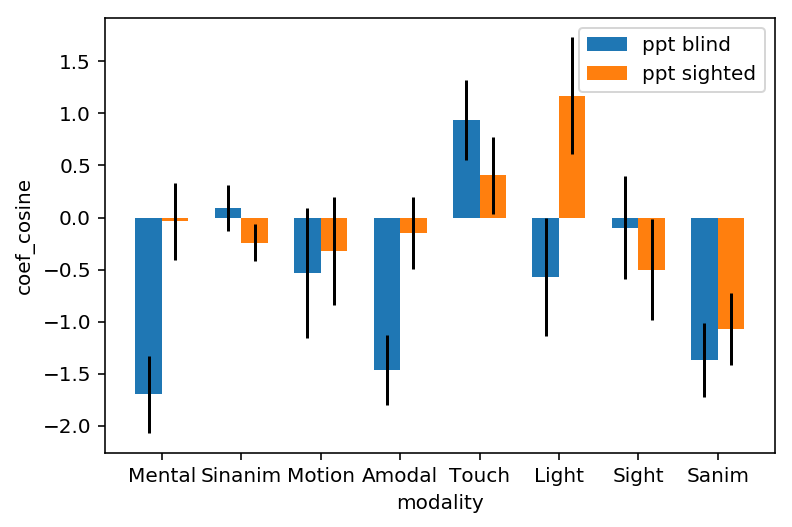

In [49]:
grouped_barplot(df_modality_coef, 'modality', 'ppt', 'coef_cosine', 'sem_cosine' )

### Visualization


Text(0.5, 1.0, 'Sighted similarity judgments by cosine distance')

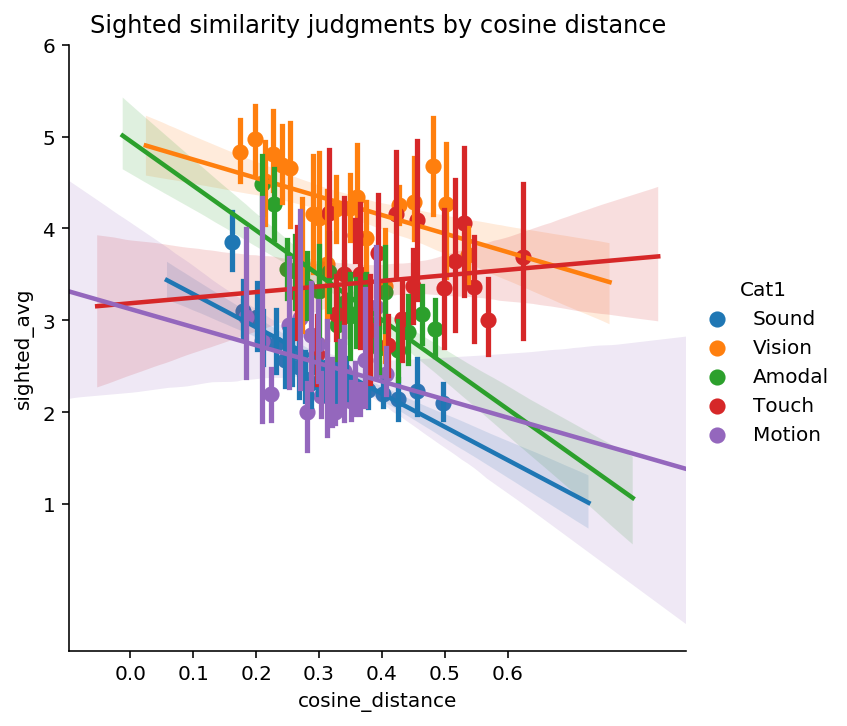

In [28]:
sns.lmplot(data = df_same,
           x = "cosine_distance", y ="sighted_avg",
           x_bins = 20, hue='Cat1'
          #hue = "S1"
          )
plt.xticks(np.arange(0, .7, .1))
plt.yticks(np.arange(1, 7, 1))
plt.title("Sighted similarity judgments by cosine distance")



Text(0.5, 1.0, 'Sighted similarity judgments by cosine distance')

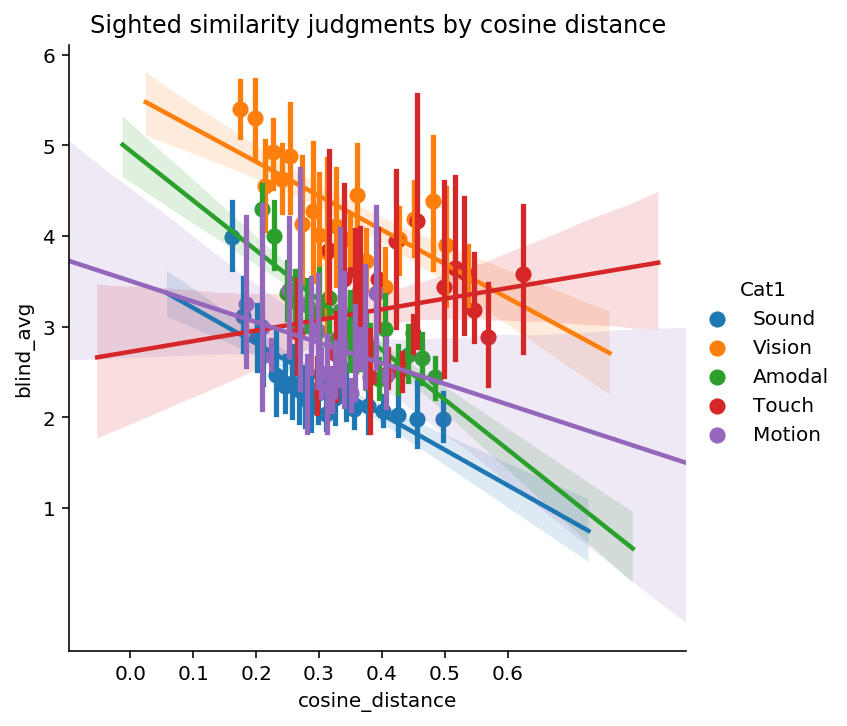

In [29]:
sns.lmplot(data = df_same,
           x = "cosine_distance", y ="blind_avg",
           x_bins = 20, hue='Cat1'
          #hue = "S1"
          )
plt.xticks(np.arange(0, .7, .1))
plt.yticks(np.arange(1, 7, 1))
plt.title("Sighted similarity judgments by cosine distance")



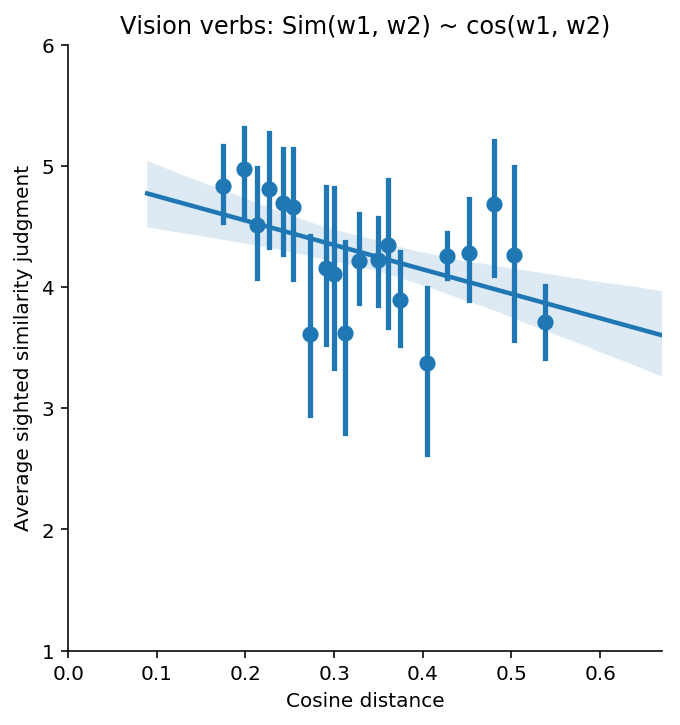

In [59]:
sns.lmplot(data = df_same[df_same['Cat1']=="Vision"],
           x = "cosine_distance", y ="sighted_avg",
           x_bins = 20,
          # hue = "S1"
          )
plt.xticks(np.arange(0, .7, .1))
plt.yticks(np.arange(1, 7, 1))
plt.title("Vision verbs: Sim(w1, w2) ~ cos(w1, w2)")
plt.ylabel("Average sighted similarity judgment")
plt.xlabel("Cosine distance")
plt.savefig("Figures/blind_sighted/plot_just_vision_sighted.png", dpi=300)

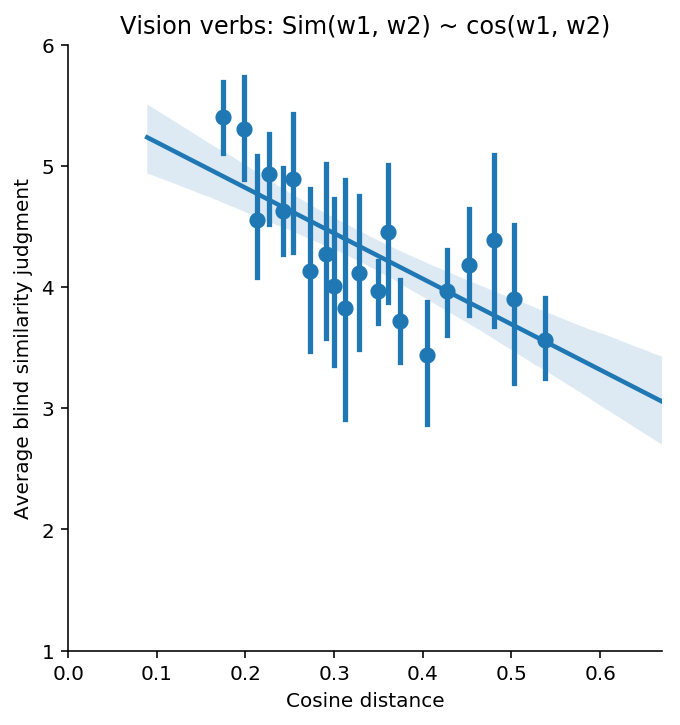

In [58]:
sns.lmplot(data = df_same[df_same['Cat1']=="Vision"],
           x = "cosine_distance", y ="blind_avg",
           x_bins = 20,
           # hue = 'S1'
          #hue = "S1"
          )
plt.xticks(np.arange(0, .7, .1))
plt.yticks(np.arange(1, 7, 1))
plt.title("Vision verbs: Sim(w1, w2) ~ cos(w1, w2)")
plt.ylabel("Average blind similarity judgment")
plt.xlabel("Cosine distance")
plt.savefig("Figures/blind_sighted/plot_just_vision_blind.png", dpi=300)